In [1]:
# https://portal.brain-map.org/atlases-and-data/rnaseq/mouse-whole-cortex-and-hippocampus-smart-seq
# https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_mouse_ctx-hpf_smart-seq/Seurat.ss.rda
# Gene expression matrix (Seurat) 	5.4 GB 	.ss.rda 
# This Seurat object contains the cell-by-gene expression matrix, with introns and exons combined.

library(Seurat)
library(ggplot2)
library(dplyr)
library(reshape2)
library(cowplot)
`%nin%` = Negate(`%in%`)

Attaching SeuratObject

Attaching sp


 次のパッケージを付け加えます: ‘dplyr’ 


 以下のオブジェクトは ‘package:stats’ からマスクされています: 

     filter, lag 


 以下のオブジェクトは ‘package:base’ からマスクされています: 

     intersect, setdiff, setequal, union 




In [2]:
source('./helper.R')

In [3]:
# load the objects without recomputing all the processing
cmb = allen_prep()
P28 = fishell_prep()
integrated = data_alignement(cmb, P28)
# meta data to get the same clustering 
# integrated@meta.data = read.csv('./0_DATA/SCRNA/integrated_meta_jun28.csv', header=T, rownames=1)

## Transfer Allen supertybe labels to Fishell dataset

In [4]:
my_levs = c('PV/SST Th','Pvalb Lpl','Pvalb Vipr2',
'Sst Calb2','Sst Chodl','Sst Crh','Sst Etv1','Sst Hpse','Sst Mme','Sst Myh8','Sst Nmbr','Sst Syndig1l',
'Vip Cp Rspo1','Vip Igfbp6','Vip Lmo1','Vip Mybpc1','Vip Pcdh11x','Vip Serpinf1',
'Lamp5 Egln3','Lamp5 Lhx6','Lamp5 Pax6','Lamp5 Pdlim5',
'Sncg Jam2 Npy2r','Sncg Krt73','Sncg Serpinf1')

sub28 = rownames(subset(integrated@meta.data,orig.ident=='CX_P28'))
subsmrt = rownames(subset(integrated@meta.data,orig.ident!='CX_P28'))
integrated@meta.data$sherry_clusters = "0"
integrated@meta.data[sub28,'sherry_clusters'] = integrated@meta.data[sub28,'RNA_snn_res.2.1']
integrated@meta.data[subsmrt,'sherry_clusters'] = integrated@meta.data[subsmrt,'supertype_label']

In [5]:
k2c = melt(table(integrated@meta.data$`RNA_snn_res.2.1`,integrated@meta.data$`integrated_snn_res.1.7`))
a2c = melt(table(integrated@meta.data$supertype_label,integrated@meta.data$`integrated_snn_res.1.7`))
colnames(k2c) = c('p28','cca','cells_p')
colnames(a2c) = c('supertype','cca','cells_a')
k2c$cells_a = 0
k2c$supertype = 0
a2c$p28 = 0
a2c$cells_p = 0
k2c = subset(k2c,cells_p>0)
a2c = subset(a2c,cells_a>0)
ka2c = rbind(k2c,a2c)
ka2c$cells = ka2c$cells_p+ka2c$cells_a
ka2c[rownames(subset(ka2c,cells_p>0)),'supertype'] = ka2c[rownames(subset(ka2c,cells_p>0)),'p28']

In [6]:
cca_sel_cl = unique(ka2c[grepl("sst|CHODL",ka2c$supertype,ignore.case = T),]$cca)
cca_sst_sub = subset(ka2c,cca %in% cca_sel_cl)

tmp_a = lapply(cca_sel_cl,function(x){
    tmp = subset(cca_sst_sub,cca==x)
    tmp$p = tmp$cells_p / sum(tmp$cells_p)
    return(c(x,subset(tmp,p>=.2)$p28))
})

tmp_b = lapply(cca_sel_cl,function(x){
    tmp = subset(cca_sst_sub,cca==x)
    tmp$p = tmp$cells_a / sum(tmp$cells_a)
    return(c(x,subset(tmp,p>=.3)$supertype))
})


cca_sel_cl = intersect(cca_sel_cl,unique(sapply(tmp_b,function(x){if(grepl('sst',x[2],ignore.case = T)){return(x[1])} else{return(-1)}})))

tmp_a = setdiff(unique(sapply(tmp_a, function(x){ if(!is.na(x[2])){return(x[2])} else{return(-1)}})),-1)
tmp_a = c(tmp_a,22)

cca_sst_sub = subset(integrated,seurat_clusters %in% cca_sel_cl)

P28_sst = subset(P28,`RNA_snn_res.2.1` %in% tmp_a)
P28_sst@meta.data$`RNA_snn_res.2.1` = droplevels(P28_sst@meta.data$`RNA_snn_res.2.1`)

## FIG1A inset 

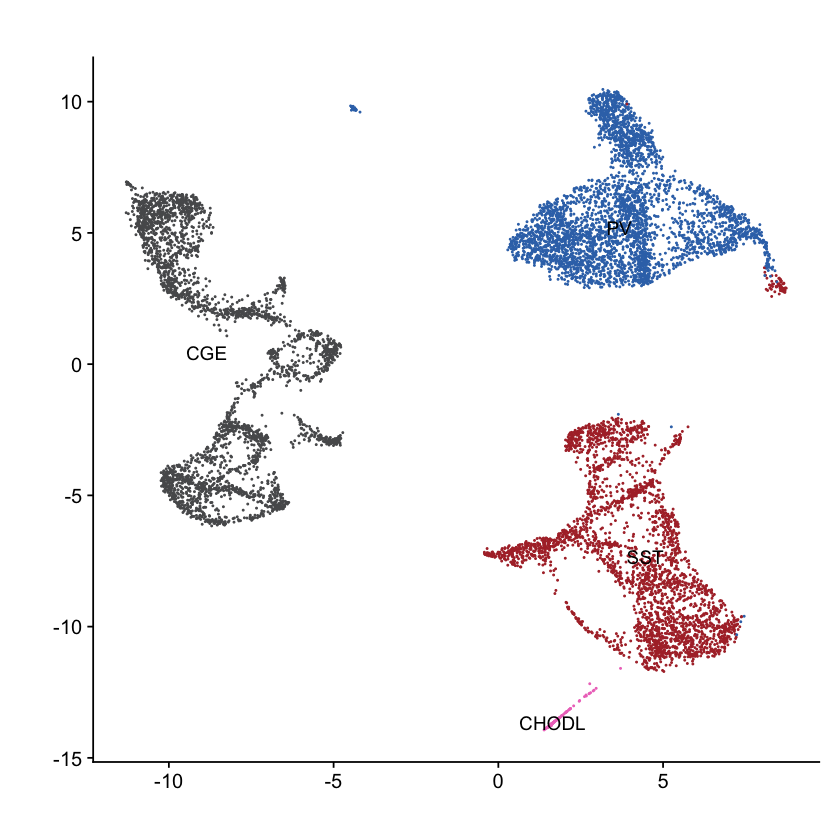

In [7]:
PV_class = c('1','2','3','0','15','6','29')
CGE_class = c('30','7','14','13','16','28','20','23','21','11','26','5','19')
CHODL_class = '24'
P28@meta.data$class_label = 'SST'

tmp_cells = rownames(subset(P28@meta.data, seurat_clusters %in% CGE_class))
P28@meta.data[tmp_cells,'class_label'] = 'CGE'

tmp_cells = rownames(subset(P28@meta.data, seurat_clusters %in% PV_class))
P28@meta.data[tmp_cells,'class_label'] = 'PV'

tmp_cells = rownames(subset(P28@meta.data, seurat_clusters %in% CHODL_class))
P28@meta.data[tmp_cells,'class_label'] = 'CHODL'

DimPlot(P28, label=T, group.by = 'class_label')+
scale_color_manual(values=list('CGE'='#58595B','PV'='#3774B7','SST'='#AF3033','CHODL'='#EE78C4'))+
NoLegend() + ggtitle('') +xlab('')+ylab('')

## FIG1A

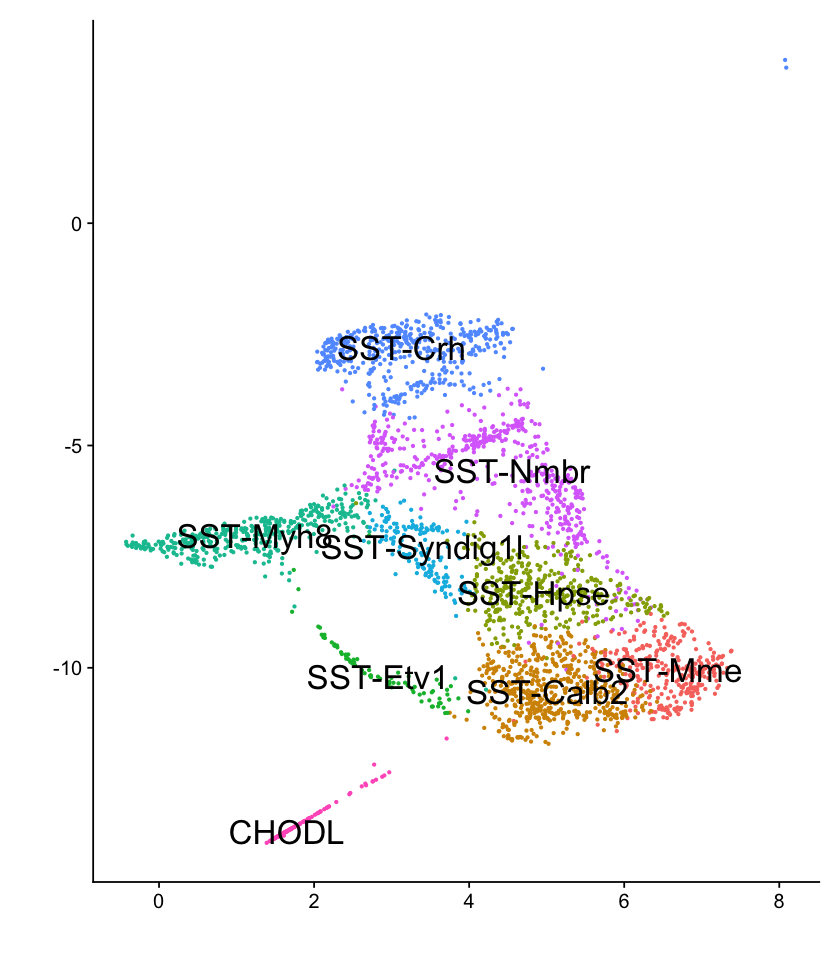

In [8]:
## FIG 1A

my_ord_v1 = c('SST-Mme', 'SST-Calb2', 'SST-Hpse', 'SST-Etv1','SST-Myh8',
              'SST-Syndig1l', 'SST-Crh','SST-Nmbr', 'CHODL')


P28_sst@meta.data$sherry_clusters = dplyr::recode(P28_sst@meta.data$seurat_clusters,
'4' ='SST-Calb2', 
'8'='SST-Crh',
'9'='SST-Myh8',
'10'='SST-Hpse',
'12'='SST-Mme',
'17'='SST-Nmbr',                                                  
'18'='SST-Nmbr',
'22'='SST-Syndig1l',                                                  
'24'='CHODL',
'27'='SST-Etv1',
'25'='Pv/Sst Th')


P28_hmap_v1 = subset(P28_sst, sherry_clusters %in% my_ord_v1)
P28_hmap_v1@meta.data$sherry_clusters = factor(droplevels(P28_hmap_v1@meta.data$sherry_clusters),
                                           levels=my_ord_v1, 
                                           ordered = T)
Idents(P28_hmap_v1) = 'sherry_clusters'
hmap_marks = c('Mme', 'Tac1', 'Calb2', 'Hpse', 'Cbln4', 'Etv1', 'Myh8',
               'Chrna2', 'Syndig1l', 'Pdyn', 'Npy', 'Crh', 'Nmbr', 'Esm1',
               'Crhr2', 'Chodl', 'Nos1')



options(repr.plot.width = 7, repr.plot.height = 8)
DimPlot(P28_hmap_v1, label=T, label.size = 7)+NoLegend()+xlab('')+ylab('')

## FIG1B

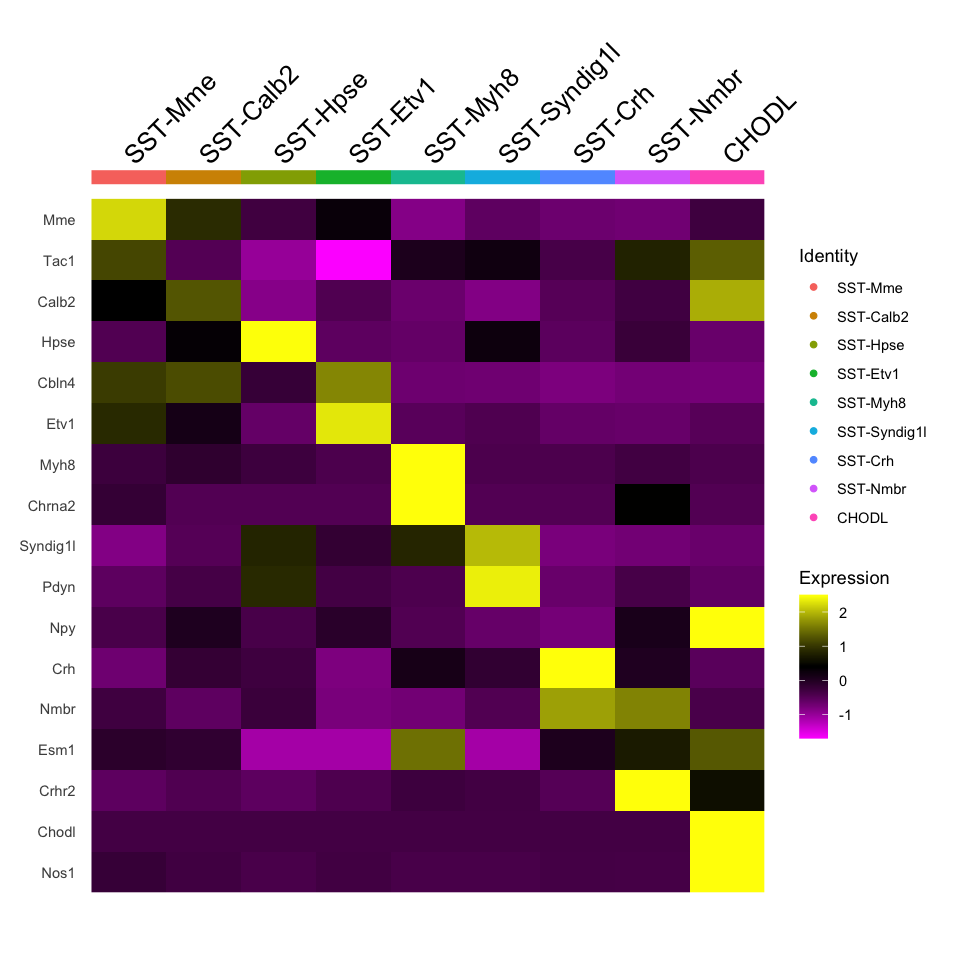

In [9]:
P28_hmap_a = AverageExpression(P28_hmap_v1,return.seurat = T, verbose = F)
options(repr.plot.width = 8, repr.plot.height = 8)
DoHeatmap(P28_hmap_a, features = hmap_marks,draw.lines = F)+ggtitle('')

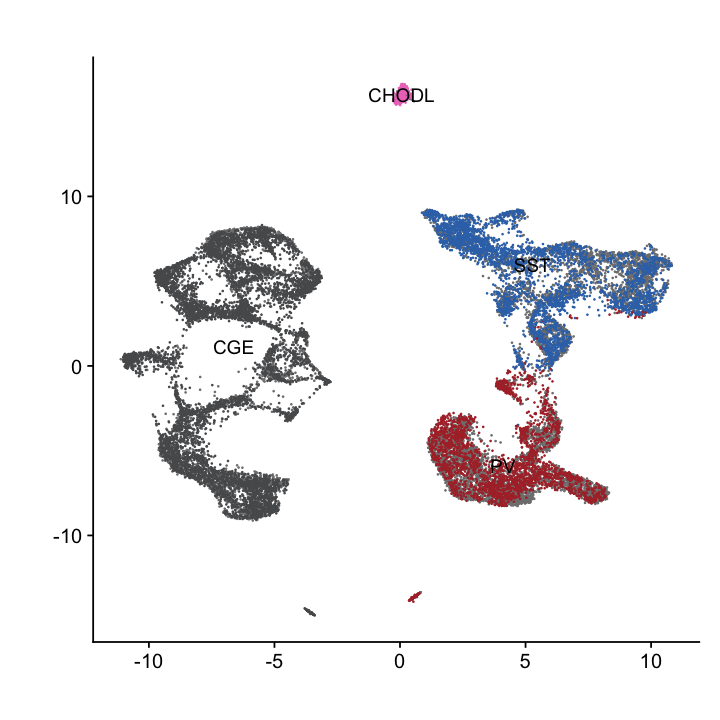

In [49]:
options(repr.plot.width = 6, repr.plot.height = 6)

integrated@meta.data$in_card = recode(integrated@meta.data$subclass_label,'Lamp5'='CGE',
                                      'Pvalb'='PV','Sncg'='CGE',
                                      'Sst'='SST','Sst Chodl'='CHODL','Vip'='CGE')
DimPlot(integrated, label=T, group.by = 'in_card')+
scale_color_manual(values=list('CGE'='#58595B','SST'='#3774B7','PV'='#AF3033','CHODL'='#EE78C4'))+
NoLegend() + ggtitle('') +xlab('')+ylab('')

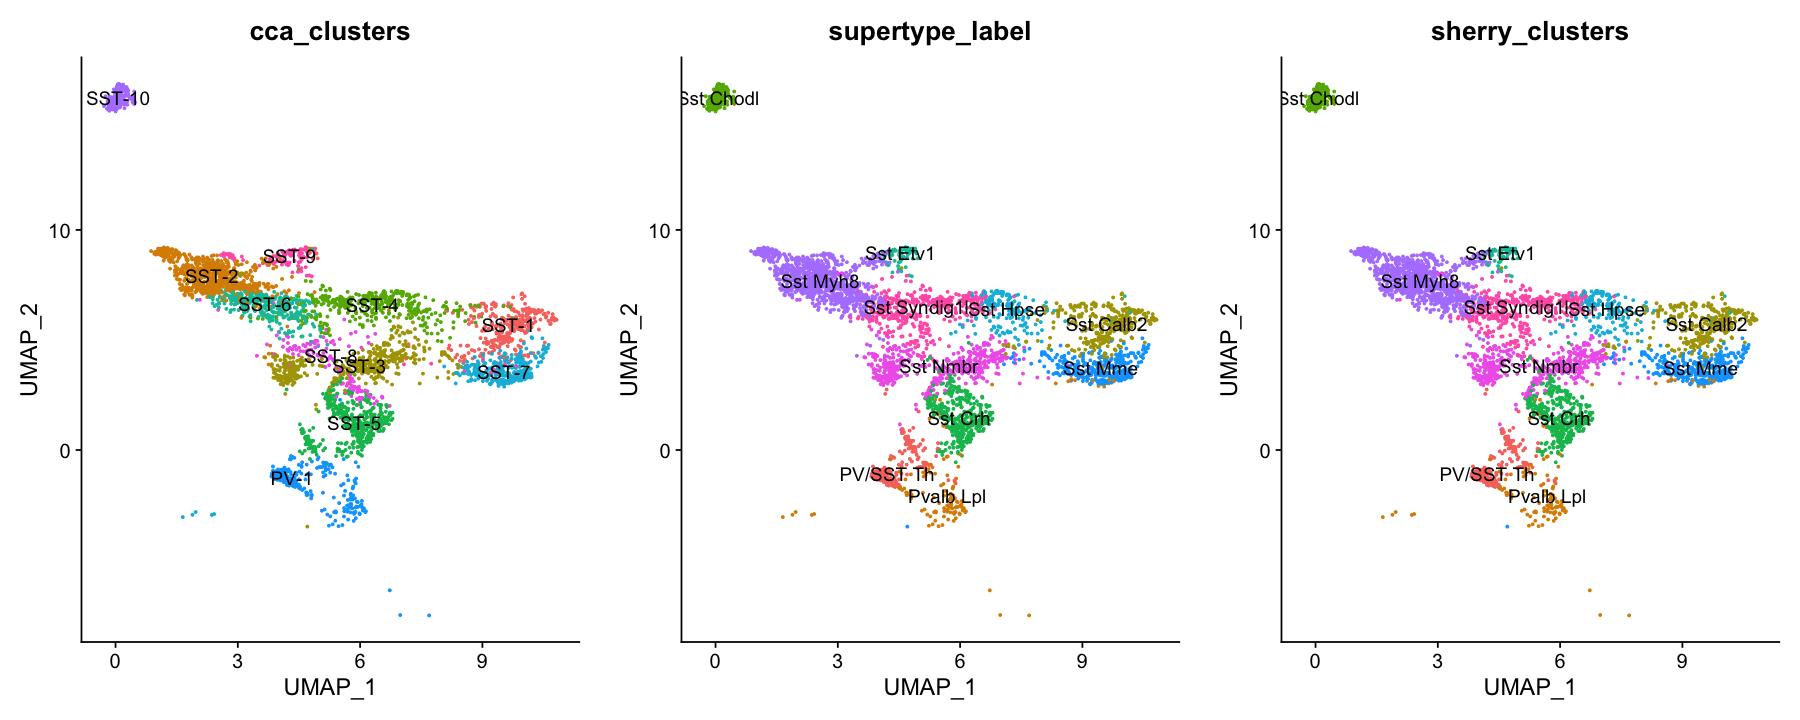

In [41]:
cca_sst_sub = subset(cca_sst_sub, supertype_label!='Sncg Jam2 Npy2r')
cca_sst_sub@meta.data$cca_clusters = recode(cca_sst_sub@meta.data$seurat_clusters, 
                                            `25`='SST-10', `8`='SST-2',`28` = 'SST-9',
                                           `18`='SST-6',`11`='SST-4',`7`='SST-1',`10`='SST-3',
                                           `27`='SST-8',`21`='SST-7',`12`='SST-5',`23`='PV-1')


options(repr.plot.width = 15, repr.plot.height = 6)
plot_grid(nrow=1,
DimPlot(cca_sst_sub,label = T, group.by='cca_clusters') + NoLegend(),
DimPlot(cca_sst_sub,label = T, group.by='supertype_label') + NoLegend(),
DimPlot(cca_sst_sub,label = T, group.by='sherry_clusters') + NoLegend())


In [76]:
fsl = melt(table(droplevels(cca_sst_sub@meta.data$cca_clusters),cca_sst_sub@meta.data$sherry_clusters))
aln = melt(table(droplevels(cca_sst_sub@meta.data$cca_clusters),cca_sst_sub@meta.data$supertype_label))
fsl$Var2 = recode(fsl$Var2, 
                 'PV/SST Th'='PV/SST-Th',
                  'Pvalb Lpl'='PV*',
                  'Sst Calb2'='SST-Calb2',
                  'Sst Chodl'='CHODL*',
                  'Sst Crh'='SST-Crh',
                  'Sst Etv1'='SST-Etv1',
                  'Sst Hpse'='SST-Hpse',
                  'Sst Mme'='SST-Mme',
                  'Sst Myh8'='SST-Myh8',
                  'Sst Nmbr'='SST-Nmbr',
                  'Sst Syndig1l'='SST-Syndig1l')
barplot_df = rbind(fsl,aln)
colnames(barplot_df) = c('cca_clusters','cell_type','cells')
barplot_df = subset(barplot_df, cells>0)
barplot_df$cca_clusters = factor(barplot_df$cca_clusters, levels=c('SST-1','SST-2','SST-3',
                                                                  'SST-4','SST-5','SST-6',
                                                                  'SST-7','SST-8','SST-9',
                                                                  'SST-10','PV-1'))
my_ord_bpl = c('PV/SST-Th',
'PV*',
'PV/SST Th',
'Pvalb Lpl',
'SST-Calb2',
'Sst Calb2',
'CHODL*',
'Sst Chodl',
'SST-Crh',
'Sst Crh',
'SST-Etv1',
'Sst Etv1',
'SST-Hpse',
'Sst Hpse',
'SST-Mme',
'Sst Mme',
'SST-Myh8',
'Sst Myh8',
'SST-Nmbr',
'Sst Nmbr',
'SST-Syndig1l',
'Sst Syndig1l')
barplot_df$cell_type = factor(barplot_df$cell_type, levels = my_ord_bpl)

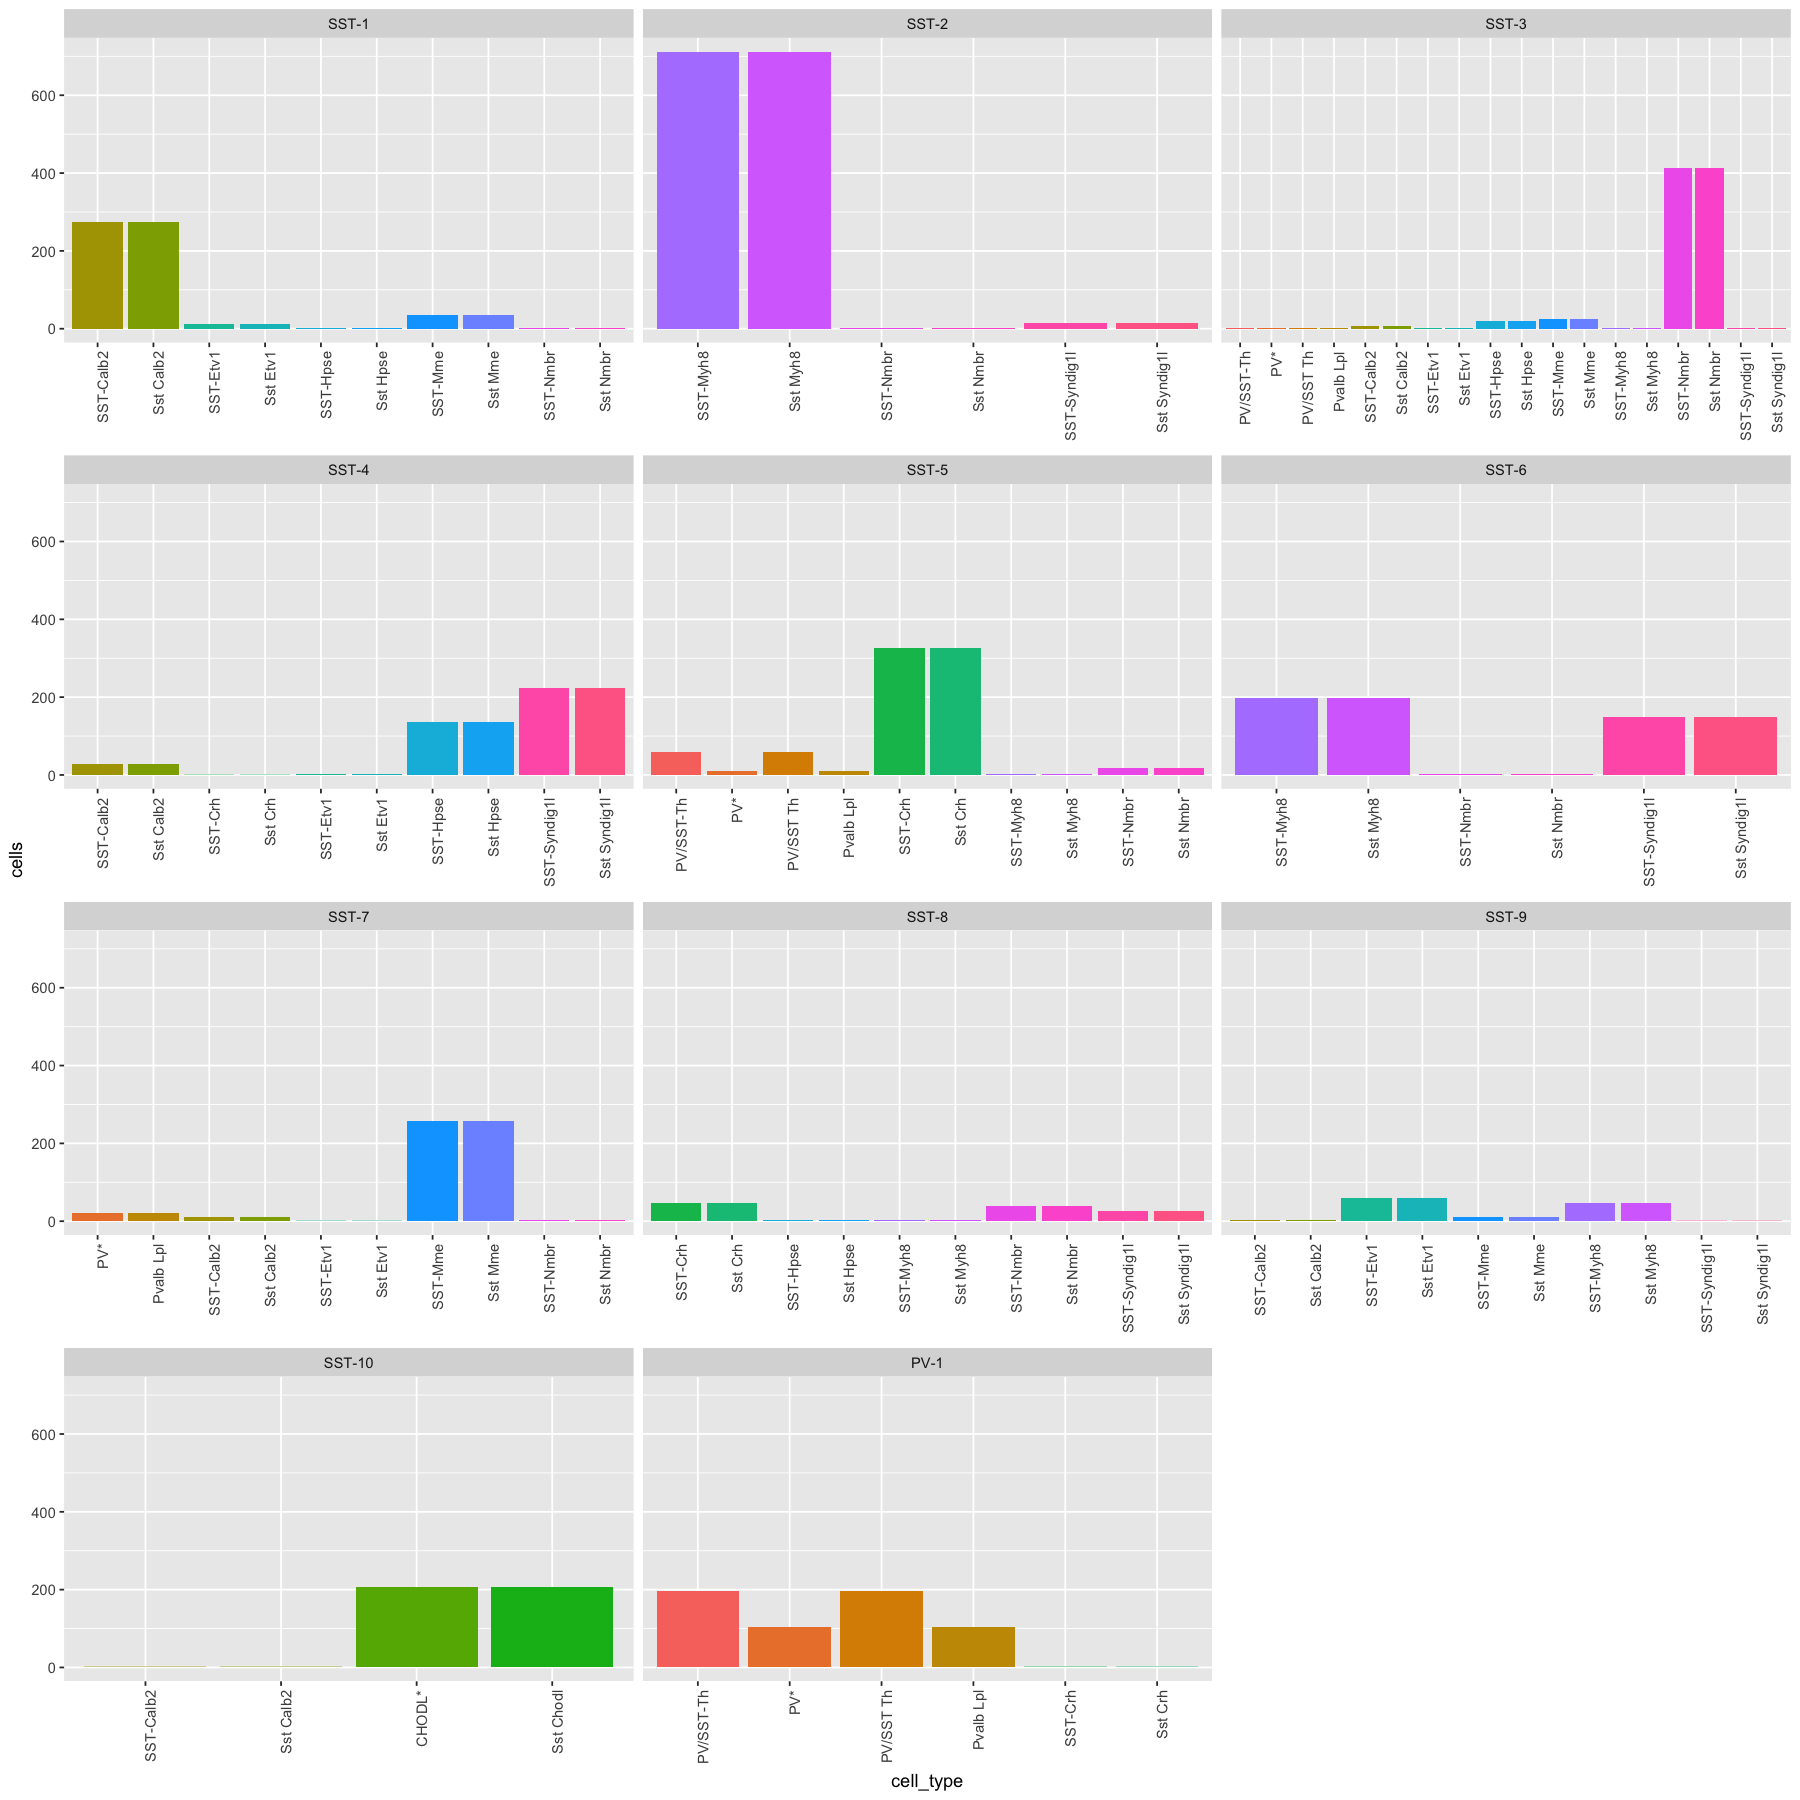

In [77]:
options(repr.plot.width = 15, repr.plot.height = 15)
ggplot(barplot_df, aes(x=cell_type,y=cells,fill=cell_type)) +
geom_col() +facet_wrap(~cca_clusters,ncol = 3,drop = T, scales = 'free_x') + NoLegend() + 
theme(axis.text.x = element_text(angle=90, hjust=1))